Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data handling

In [ ]:
import pandas as pd

csv_file_path = '/content/drive/MyDrive/cleaned_labels.csv'

df = pd.read_csv(csv_file_path)

total_rows = len(df)

print(f"Total number of items (rows) in '{csv_file_path}': {total_rows}")


Total number of items (rows) in '/content/drive/MyDrive/cleaned_labels.csv': 8408


In [ ]:
import pandas as pd

csv_files = [
    '/content/drive/MyDrive/cutmixed_images/labelsX.csv',
    '/content/drive/MyDrive/cutmixed_images/labelsY.csv',
    '/content/drive/MyDrive/cutmixed_images/labelsZ.csv',
   '/content/drive/MyDrive/cleaned_labels.csv'
]

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)

    if 'image' in df.columns and 'level' in df.columns:
        df = df.rename(columns={'image': 'filename', 'level': 'label'})
    elif 'filename' in df.columns and 'labels' in df.columns:
        df = df.rename(columns={'labels': 'label'})

    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('/content/drive/MyDrive/merged_labels.csv', index=False)

print("CSV files standardized and merged successfully.")


CSV files standardized and merged successfully.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/merged_labels.csv')
print(data.value_counts().sum())
print(data['label'].unique())
print(data['label'].value_counts().unique())
data.head()

9833
[4 3 1 0 2]
[6150 1283  800]


,filename,label
0,cutmixed_4_0.jpeg,4
1,cutmixed_4_1.jpeg,4
2,cutmixed_4_2.jpeg,4
3,cutmixed_4_3.jpeg,4
4,cutmixed_4_4.jpeg,4


In [ ]:
class_counts = merged_df['label'].value_counts()

print("Number of unique classes:", len(class_counts))
print("\nClass distribution:\n", class_counts)

Number of unique classes: 5

Class distribution:
 label
0    6150
2    1283
4     800
1     800
3     800
Name: count, dtype: int64


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/merged_labels.csv')
print(data.value_counts().sum())
print(data['label'].unique())
print(data['label'].value_counts().unique())
data.head()

9833
[4 3 1 0 2]
[6150 1283  800]


,filename,label
0,cutmixed_4_0.jpeg,4
1,cutmixed_4_1.jpeg,4
2,cutmixed_4_2.jpeg,4
3,cutmixed_4_3.jpeg,4
4,cutmixed_4_4.jpeg,4


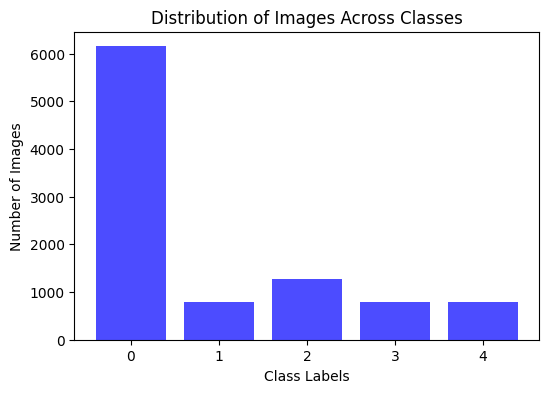

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


class_counts = data['label'].value_counts().sort_index()  # Get counts and sort by class labels


plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color='blue', alpha=0.7)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')


plt.xticks(class_counts.index)

plt.show()


In [ ]:
print("Number of images in each class:")
for level, count in class_counts.items():
    print(f"Class {level}: {count} images")

Number of images in each class:
Class 0: 6150 images
Class 1: 800 images
Class 2: 1283 images
Class 3: 800 images
Class 4: 800 images


Class distribution after undersampling: {0: 800, 1: 800, 2: 800, 3: 800, 4: 800}
Resampled class counts: {0: 800, 1: 800, 2: 800, 3: 800, 4: 800}


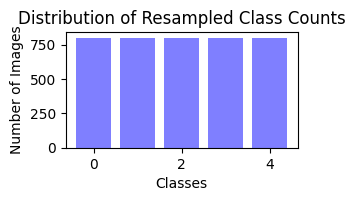

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X = data['filename']
y = data['label']

X_array = X.values.reshape(-1, 1)
y_array = y.values

class_counts = {0: 6150, 1: 800, 2: 1283, 3: 800, 4: 800}
target_count = min(class_counts.values())

undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys()})
X_under, y_under = undersampler.fit_resample(X_array, y_array)

print("Class distribution after undersampling:", dict(zip(*np.unique(y_under, return_counts=True))))

oversampler = RandomOverSampler(sampling_strategy={label: target_count for label in np.unique(y_under)})
X_resampled, y_resampled = oversampler.fit_resample(X_under, y_under)

unique, counts = np.unique(y_resampled, return_counts=True)
resampled_class_counts = dict(zip(unique, counts))
print("Resampled class counts:", resampled_class_counts)

plt.figure(figsize=(3, 1.5))
plt.bar(resampled_class_counts.keys(), resampled_class_counts.values(), color='blue', alpha=0.5)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Resampled Class Counts')
plt.show()


In [ ]:
new_X = []
for i in X_resampled:
  for j in i:
    new_X.append(j)

In [ ]:
y_resampled

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
resampled_data = {'filename': new_X,
        'label': y_resampled}

balanced_data = pd.DataFrame(resampled_data)


balanced_data.sample(10)

,filename,label
3600,13022_right,4
170,18562_left,0
2427,cutmixed_class3_491.jpeg,3
126,17396_right,0
11,10391_right,0
3441,cutmixed_4_340.jpeg,4
2436,10606_left,3
1107,15835_left,1
3991,cutmixed_4_65.jpeg,4
2665,12490_right,3


In [ ]:
print(balanced_data.value_counts().sum())
print(balanced_data['label'].unique())
print(balanced_data['label'].value_counts().unique())

4000
[0 1 2 3 4]
[800]


In [ ]:
balanced_data['filename'] = balanced_data['filename']+'.jpeg'
balanced_data['label'] = balanced_data['label'].astype(str)
balanced_data.head()

,filename,label
0,17838_left.jpeg,0
1,17720_left.jpeg,0
2,18870_left.jpeg,0
3,15932_left.jpeg,0
4,18536_left.jpeg,0


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

Ben graham's preprocessing

In [ ]:
import cv2
import numpy as np
import os

def scale_radius(img, scale):
    """
    Scales the image to a specified radius.
    """
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)

def subtract_local_average_color(img):
    """
    Subtracts the local average color.
    """
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0),  10), -4, 128)
    return img

def clip_image(img, target_size=(224, 224)):
    """
    Clips the image to 90% size to remove boundary effects, and optionally applies resizing and normalization.
    """
    img_a = scale_radius(img, 300)
    img = subtract_local_average_color(img_a)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = int(300 * 0.9)
    cv2.circle(mask, center, radius, 255, -1)
    img_masked = cv2.bitwise_and(img,img, mask=mask)

    # # Resize the image
    img_resized = cv2.resize(img_masked, target_size)


    return img_resized


In [ ]:
import os
import pandas as pd

cutmixed_train = train[train['filename'].str.startswith('cutmixed_')]
cutmixed_val = val[val['filename'].str.startswith('cutmixed_')]

print("Total cutmixed_ images in train:", len(cutmixed_train))
print("Total cutmixed_ images in val:", len(cutmixed_val))

cutmixed_train['exists'] = cutmixed_train['filename'].apply(lambda x: os.path.exists(os.path.join('/content/drive/MyDrive/train_dr', x)))
cutmixed_val['exists'] = cutmixed_val['filename'].apply(lambda x: os.path.exists(os.path.join('/content/drive/MyDrive/train_dr', x)))

missing_train_files = cutmixed_train[~cutmixed_train['exists']]
missing_val_files = cutmixed_val[~cutmixed_val['exists']]

print("Missing train files:", missing_train_files['filename'].tolist())
print("Missing val files:", missing_val_files['filename'].tolist())

Total cutmixed_ images in train: 1158
Total cutmixed_ images in val: 267
Missing train files: ['cutmixed_4_317.jpeg.jpeg', 'cutmixed_4_19.jpeg.jpeg', 'cutmixed_class3_415.jpeg.jpeg', 'cutmixed_127.jpeg.jpeg', 'cutmixed_174.jpeg.jpeg', 'cutmixed_58.jpeg.jpeg', 'cutmixed_class3_55.jpeg.jpeg', 'cutmixed_4_125.jpeg.jpeg', 'cutmixed_4_319.jpeg.jpeg', 'cutmixed_4_175.jpeg.jpeg', 'cutmixed_class3_221.jpeg.jpeg', 'cutmixed_4_299.jpeg.jpeg', 'cutmixed_class3_156.jpeg.jpeg', 'cutmixed_74.jpeg.jpeg', 'cutmixed_class3_433.jpeg.jpeg', 'cutmixed_4_621.jpeg.jpeg', 'cutmixed_142.jpeg.jpeg', 'cutmixed_4_152.jpeg.jpeg', 'cutmixed_4_580.jpeg.jpeg', 'cutmixed_4_170.jpeg.jpeg', 'cutmixed_77.jpeg.jpeg', 'cutmixed_4_188.jpeg.jpeg', 'cutmixed_4_37.jpeg.jpeg', 'cutmixed_4_73.jpeg.jpeg', 'cutmixed_4_128.jpeg.jpeg', 'cutmixed_4_427.jpeg.jpeg', 'cutmixed_class3_516.jpeg.jpeg', 'cutmixed_class3_439.jpeg.jpeg', 'cutmixed_4_584.jpeg.jpeg', 'cutmixed_class3_167.jpeg.jpeg', 'cutmixed_class3_440.jpeg.jpeg', 'cutmixed_4

<ipython-input-19-77bcb2fc647d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutmixed_train['exists'] = cutmixed_train['filename'].apply(lambda x: os.path.exists(os.path.join('/content/drive/MyDrive/train_dr', x)))
<ipython-input-19-77bcb2fc647d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutmixed_val['exists'] = cutmixed_val['filename'].apply(lambda x: os.path.exists(os.path.join('/content/drive/MyDrive/train_dr', x)))


In [ ]:
cutmixed_train['filename'] = cutmixed_train['filename'].apply(lambda x: os.path.basename(x))
cutmixed_val['filename'] = cutmixed_val['filename'].apply(lambda x: os.path.basename(x))


<ipython-input-20-6262e7331acc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutmixed_train['filename'] = cutmixed_train['filename'].apply(lambda x: os.path.basename(x))
<ipython-input-20-6262e7331acc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutmixed_val['filename'] = cutmixed_val['filename'].apply(lambda x: os.path.basename(x))


In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

def check_filenames(df, directory):
    missing_files = [f for f in df['filename'] if not os.path.exists(os.path.join(directory, f))]
    if missing_files:
        print(f"Missing files: {len(missing_files)}")
        print("Sample missing files:", missing_files[:5])
    return len(missing_files) == 0

image_directory = '/content/drive/MyDrive/train_dr'

if not check_filenames(train, image_directory) or not check_filenames(val, image_directory):
    print("Some image files are missing. Please verify the paths and filenames.")
else:
    print("All files are present.")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=clip_image
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=clip_image
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_directory,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=image_directory,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Images validated and generators created successfully.")


Missing files: 1158
Sample missing files: ['cutmixed_4_317.jpeg.jpeg', 'cutmixed_4_19.jpeg.jpeg', 'cutmixed_class3_415.jpeg.jpeg', 'cutmixed_127.jpeg.jpeg', 'cutmixed_174.jpeg.jpeg']
Some image files are missing. Please verify the paths and filenames.
Found 2042 validated image filenames belonging to 5 classes.
Found 533 validated image filenames belonging to 5 classes.
Images validated and generators created successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1158 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 267 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Correct filenames by removing extra extensions
train['filename'] = train['filename'].apply(lambda x: x.replace('.jpeg.jpeg', '.jpeg'))
val['filename'] = val['filename'].apply(lambda x: x.replace('.jpeg.jpeg', '.jpeg'))

# Re-check if files exist after correcting filenames
print("Checking corrected filenames...")
missing_train_files = [f for f in train['filename'] if not os.path.exists(os.path.join(image_directory, f))]
missing_val_files = [f for f in val['filename'] if not os.path.exists(os.path.join(image_directory, f))]

print(f"Missing files in train after correction: {len(missing_train_files)}")
print(f"Missing files in val after correction: {len(missing_val_files)}")

if missing_train_files:
    print("Sample missing train files:", missing_train_files[:5])
if missing_val_files:
    print("Sample missing val files:", missing_val_files[:5])


Checking corrected filenames...
Missing files in train after correction: 0
Missing files in val after correction: 0


In [ ]:
# Filter cutmixed_ images
cutmixed_train = train[train['filename'].str.startswith('cutmixed_')]
cutmixed_val = val[val['filename'].str.startswith('cutmixed_')]

# Print counts to verify
print(f"Total cutmixed_ images in train: {len(cutmixed_train)}")
print(f"Total cutmixed_ images in val: {len(cutmixed_val)}")

# Combine the filtered cutmixed_ images with the original DataFrames
train_combined = pd.concat([train, cutmixed_train]).drop_duplicates(subset='filename')
val_combined = pd.concat([val, cutmixed_val]).drop_duplicates(subset='filename')

# Print counts to verify combined DataFrames
print(f"Total images in combined train DataFrame: {len(train_combined)}")
print(f"Total images in combined val DataFrame: {len(val_combined)}")

Total cutmixed_ images in train: 1158
Total cutmixed_ images in val: 267
Total images in combined train DataFrame: 3200
Total images in combined val DataFrame: 800


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=clip_image
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=clip_image
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_combined,
    directory=image_directory,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_combined,
    directory=image_directory,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Images validated and generators created successfully.")


Found 3200 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.
Images validated and generators created successfully.


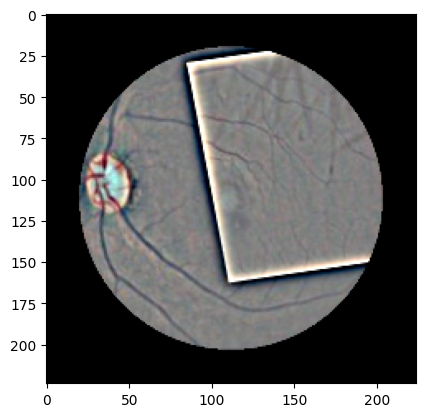

In [ ]:
plt.imshow(next(train_generator)[0][0])

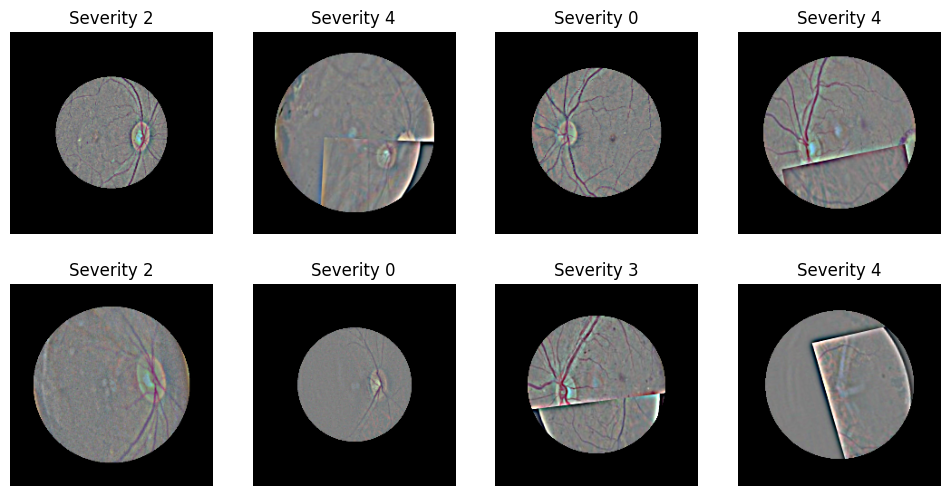

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (12, 6))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x)
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [ ]:
import os

checkpoint_dir = '/content/drive/MyDrive/effi_ensemb_cut/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

EfficientNet-B7 with Residual block

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# Define the RA block function
def RA_block(input_tensor):
    # Path 1: Three consecutive convolutions
    conv1 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
    conv1 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(3, 3), padding='same', activation='relu')(conv1)
    conv1 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(3, 3), padding='same', activation='relu')(conv1)

    # Path 2: Direct convolution
    conv2 = Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), padding='same', activation='relu')(input_tensor)

    # Combine paths (without attention)
    output_tensor = Add()([conv1, conv2])
    return output_tensor

# Build EfficientNetB7 model with ImageNet weights and input size according to its scaling
efficientnet_b7 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Input size scaled up

# Freeze the EfficientNetB7 model layers
for layer in efficientnet_b7.layers:
    layer.trainable = False

# Apply RA block after EfficientNetB7
x = efficientnet_b7.output
x = RA_block(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# First Dense Layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Second Dense Layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
NUM_CLASSES = 5
efficientnet_b7_pred = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
best_model_efficientnet_b7 = Model(inputs=efficientnet_b7.input, outputs=efficientnet_b7_pred)

# Compile the model with the specified learning rate and custom loss
best_model_efficientnet_b7.compile(
    optimizer=Adam(learning_rate=0.0001),  # Specified learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'efficientnet_b7_best_model_1.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Callbacks: Early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    checkpoint_callback
]

# Train the model
history_efficientnet_b7 = best_model_efficientnet_b7.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 4242s 39s/step - accuracy: 0.1931 - loss: 22.7753 - val_accuracy: 0.2212 - val_loss: 28.1232 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.1902 - loss: 18.7171 - val_accuracy: 0.1950 - val_loss: 16.8669 - learning_rate: 1.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 543s 5s/step - accuracy: 0.1978 - loss: 15.6502 - val_accuracy: 0.2138 - val_loss: 17.8691 - learning_rate: 1.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.2119 - loss: 13.4091 - val_accuracy: 0.2138 - val_loss: 15.7077 - learning_rate: 1.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.2240 - loss: 11.7761 - val_accuracy: 0.2138 - val_loss: 11.5831 - learning_rate: 1.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 514s 5s/step - accuracy: 0.1947 - loss: 10.6489 - val_accuracy: 0.1775 - val_loss: 14.0097 - learning_rate: 1.0000e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/s

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
efficient_model = load_model('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_1.keras')

# Set a new learning rate for the optimizer
new_learning_rate = 2.0000e-05   # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
efficient_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_2.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10),
    checkpoint_callback
]


# Continue training for more epochs with the adjusted learning rate
history = efficient_model.fit(
    train_generator, validation_data=val_generator,
    epochs=85,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/85


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2681s 24s/step - accuracy: 0.2022 - loss: 7.6099 - val_accuracy: 0.2100 - val_loss: 7.7209 - learning_rate: 2.0000e-05
Epoch 2/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 632s 6s/step - accuracy: 0.1967 - loss: 7.0353 - val_accuracy: 0.2288 - val_loss: 6.6513 - learning_rate: 2.0000e-05
Epoch 3/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 578s 5s/step - accuracy: 0.2037 - loss: 6.6517 - val_accuracy: 0.1813 - val_loss: 6.2842 - learning_rate: 2.0000e-05
Epoch 4/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 617s 6s/step - accuracy: 0.2083 - loss: 6.2368 - val_accuracy: 0.2075 - val_loss: 6.1810 - learning_rate: 2.0000e-05
Epoch 5/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 639s 6s/step - accuracy: 0.2106 - loss: 5.9571 - val_accuracy: 0.2300 - val_loss: 5.5336 - learning_rate: 2.0000e-05
Epoch 6/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - accuracy: 0.2158 - loss: 5.6755 - val_accuracy: 0.1863 - val_loss: 5.7703 - learning_rate: 2.0000e-05
Epoch 7/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
efficient_model = load_model('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_2.keras')

# Set a new learning rate for the optimizer
new_learning_rate = 2.0000e-05   # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
efficient_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_3.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10),
    checkpoint_callback
]


# Continue training for more epochs with the adjusted learning rate
history = efficient_model.fit(
    train_generator, validation_data=val_generator,
    epochs=85,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/85


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2264s 21s/step - accuracy: 0.1946 - loss: 4.6933 - val_accuracy: 0.1912 - val_loss: 4.7560 - learning_rate: 2.0000e-05
Epoch 2/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 614s 6s/step - accuracy: 0.2058 - loss: 4.4911 - val_accuracy: 0.2362 - val_loss: 4.1255 - learning_rate: 2.0000e-05
Epoch 3/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.2060 - loss: 4.4607 - val_accuracy: 0.1925 - val_loss: 4.5725 - learning_rate: 2.0000e-05
Epoch 4/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.2017 - loss: 4.3800 - val_accuracy: 0.1900 - val_loss: 4.2749 - learning_rate: 2.0000e-05
Epoch 5/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 470s 4s/step - accuracy: 0.2001 - loss: 4.3487 - val_accuracy: 0.1787 - val_loss: 6.4852 - learning_rate: 2.0000e-05
Epoch 6/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - accuracy: 0.2095 - loss: 4.2637 - val_accuracy: 0.1775 - val_loss: 4.9307 - learning_rate: 4.0000e-06
Epoch 7/85
100/100 ━━━━━━━━━━━━━━━━━━━━ 613s 6s/step - accuracy: 0.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
efficient_model = load_model('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_3.keras')

# Set a new learning rate for the optimizer
new_learning_rate = 4.0000e-06  # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
efficient_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_4.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-10),
    checkpoint_callback
]


# Continue training for more epochs with the adjusted learning rate
history = efficient_model.fit(
    train_generator, validation_data=val_generator,
    epochs=40,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 734s 6s/step - accuracy: 0.1984 - loss: 4.1730 - val_accuracy: 0.2237 - val_loss: 3.7891 - learning_rate: 4.0000e-06
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.1998 - loss: 4.1241 - val_accuracy: 0.1925 - val_loss: 3.9126 - learning_rate: 4.0000e-06
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 495s 4s/step - accuracy: 0.2148 - loss: 4.1137 - val_accuracy: 0.1825 - val_loss: 3.8061 - learning_rate: 4.0000e-06
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 531s 5s/step - accuracy: 0.1977 - loss: 4.1411 - val_accuracy: 0.2412 - val_loss: 3.8654 - learning_rate: 4.0000e-06
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 462s 4s/step - accuracy: 0.2022 - loss: 4.0711 - val_accuracy: 0.1825 - val_loss: 3.8947 - learning_rate: 2.0000e-06
Epoch 6/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - accuracy: 0.1926 - loss: 4.1313 - val_accuracy: 0.1925 - val_loss: 3.8765 - learning_rate: 2.0000e-06
Epoch 7/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - acc

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

# Load the saved model
efficient_model = load_model('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_4.keras')

# Set a new learning rate for the optimizer
new_learning_rate = 1.0000e-06  # Set the new learning rate

# Re-compile the model with the new learning rate
optimizer = Adam(learning_rate=new_learning_rate)
efficient_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('/content/drive/MyDrive/effi_ensemb_cut/efficientnet_b7_best_model_5.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-12),
    checkpoint_callback
]


# Continue training for more epochs with the adjusted learning rate
history = efficient_model.fit(
    train_generator, validation_data=val_generator,
    epochs=26,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/26


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2273s 20s/step - accuracy: 0.2275 - loss: 4.0300 - val_accuracy: 0.1887 - val_loss: 3.8092 - learning_rate: 1.0000e-06
Epoch 2/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 633s 6s/step - accuracy: 0.1959 - loss: 4.1258 - val_accuracy: 0.1912 - val_loss: 3.7773 - learning_rate: 1.0000e-06
Epoch 3/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 644s 6s/step - accuracy: 0.2228 - loss: 4.0951 - val_accuracy: 0.2225 - val_loss: 3.7702 - learning_rate: 1.0000e-06
Epoch 4/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - accuracy: 0.2170 - loss: 4.0461 - val_accuracy: 0.2125 - val_loss: 3.7453 - learning_rate: 1.0000e-06
Epoch 5/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 594s 6s/step - accuracy: 0.2219 - loss: 3.9991 - val_accuracy: 0.2100 - val_loss: 3.7298 - learning_rate: 1.0000e-06
Epoch 6/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.2219 - loss: 4.0293 - val_accuracy: 0.2237 - val_loss: 3.7655 - learning_rate: 1.0000e-06
Epoch 7/26
100/100 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.

In [ ]:
val_loss, val_accuracy =  efficient_model.evaluate(val_generator, steps=len(val_generator))

print("Validation Accuracy:", val_accuracy)
print("Validation Loss:", val_loss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.2295 - loss: 3.7638
Validation Accuracy: 0.22499999403953552
Validation Loss: 3.774226427078247


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

# # Load the saved model
# model_save_path = '/content/drive/MyDrive/ensemble_model_cut/inception_V3_c3.keras'
# inception_model = load_model(model_save_path)

batch_size = 16
all_predictions = []

true_Y_labels = []

for i in range(len(val_generator)):
    x_batch, y_batch = next(val_generator)
    batch_predictions = efficient_model.predict(x_batch)
    all_predictions.append(batch_predictions)
    true_Y_labels.append(y_batch)
pred_Y = np.concatenate(all_predictions)
true_Y = np.concatenate(true_Y_labels)

pred_Y_labels = np.argmax(pred_Y, axis=1)
true_Y_labels = np.argmax(true_Y, axis=1)

report = classification_report(true_Y_labels, pred_Y_labels, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
              precision   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


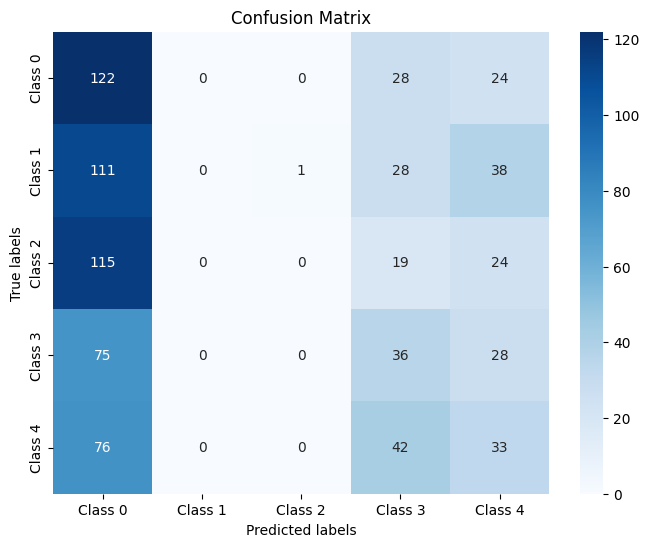

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_Y_labels, pred_Y_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

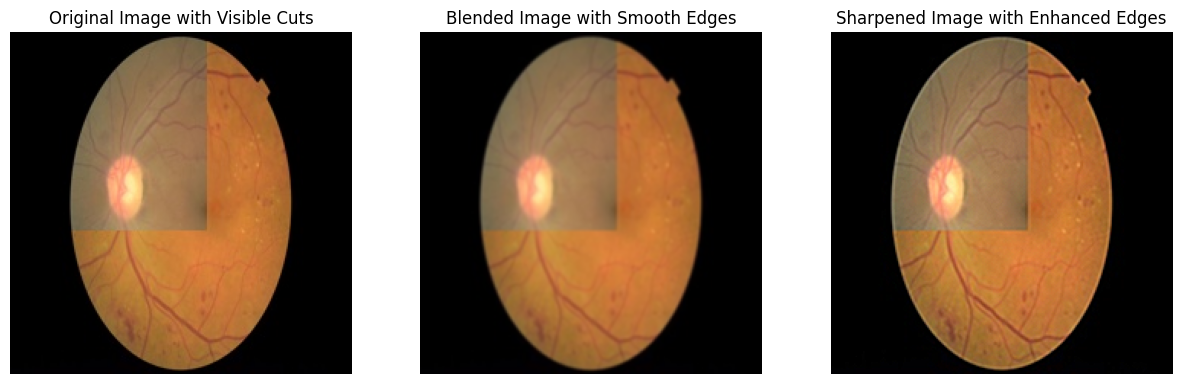

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the cutmixed image
image_path = "/content/drive/MyDrive/train_dr/cutmixed_class3_547.jpeg"
image = cv2.imread(image_path)

# Check if image was loaded correctly
if image is None:
    print(f"Error loading image from {image_path}")
else:
    # Convert image to RGB (OpenCV loads it as BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply Gaussian blur to the edges of the image to blend the cut lines
    blended_image = cv2.GaussianBlur(image_rgb, (3, 3), 0)

    # Apply a sharpening filter (interpreting as Bengraham's kernel)
    # This kernel enhances the edges by boosting high-frequency details
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    # Apply the sharpening kernel to the blended image
    sharpened_image = cv2.filter2D(blended_image, -1, kernel)

    # Plot original, blended, and sharpened images for comparison
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image with Visible Cuts')
    plt.axis('off')  # Hide axis for a cleaner display

    # Display blended image (smoothed edges)
    plt.subplot(1, 3, 2)
    plt.imshow(blended_image)
    plt.title('Blended Image with Smooth Edges')
    plt.axis('off')  # Hide axis for a cleaner display

    # Display sharpened image (enhanced edges)
    plt.subplot(1, 3, 3)
    plt.imshow(sharpened_image)
    plt.title('Sharpened Image with Enhanced Edges')
    plt.axis('off')  # Hide axis for a cleaner display

    # Show the result
    plt.show()


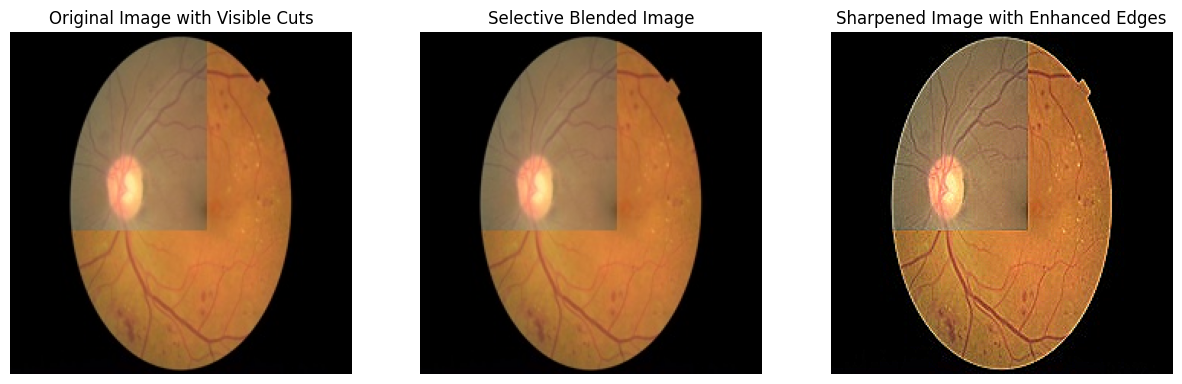

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the cutmixed image
image_path = "/content/drive/MyDrive/train_dr/cutmixed_class3_547.jpeg"
image = cv2.imread(image_path)

# Check if image was loaded correctly
if image is None:
    print(f"Error loading image from {image_path}")
else:
    # Convert image to RGB (OpenCV loads it as BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert to grayscale to detect edges based on intensity
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Use edge detection (Canny) to find regions where color changes abruptly
    edges = cv2.Canny(gray_image, 100, 200)

    # Create a mask for blending only where edges are detected
    mask = cv2.dilate(edges, None, iterations=1)  # Dilate edges to cover a wider area

    # Convert mask to 3 channels to match the image
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    # Apply Gaussian blur selectively where the mask is non-zero (blending along detected edges)
    blurred_image = image_rgb.copy()
    blurred_image[mask_rgb != 0] = cv2.GaussianBlur(image_rgb, (1,1), 0)[mask_rgb != 0]

    # Apply a sharpening filter (interpreting as Bengraham's kernel) to the entire image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    sharpened_image = cv2.filter2D(blurred_image, -1, kernel)

    # Plot original, blended, and sharpened images for comparison
    plt.figure(figsize=(15, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image with Visible Cuts')
    plt.axis('off')  # Hide axis for a cleaner display

    # Display blended image (smoothed edges selectively)
    plt.subplot(1, 3, 2)
    plt.imshow(blurred_image)
    plt.title('Selective Blended Image')
    plt.axis('off')  # Hide axis for a cleaner display

    # Display sharpened image (enhanced edges)
    plt.subplot(1, 3, 3)
    plt.imshow(sharpened_image)
    plt.title('Sharpened Image with Enhanced Edges')
    plt.axis('off')  # Hide axis for a cleaner display

    # Show the result
    plt.show()
